In [ ]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
 
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
 
import plotly.graph_objs as go
 
from datetime import datetime
 
import pandas as pd
 
# задаём данные для отрисовки
from sqlalchemy import create_engine
 
# пример подключения к базе данных для Postresql
#db_config = {'user': 'my_user',
#             'pwd': 'my_user_password',
#             'host': 'localhost',
#             'port': 5432,
#             'db': 'games'}
#engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
#                                                            db_config['pwd'],
#                                                            db_config['host'],
#                                                            db_config['port'],
#                                                            db_config['db']))
# пример подключения к базе данных для Sqlite
engine = create_engine('sqlite:////db/games.db', echo=False)
 
# получаем сырые данные
query = '''
            SELECT * FROM agg_games_year_genre_platform
        '''
agg_games_year_genre_platform = pd.io.sql.read_sql(query, con = engine)
agg_games_year_genre_platform['year_of_release'] = pd.to_datetime(agg_games_year_genre_platform['year_of_release'])
 
query = '''
            SELECT * FROM agg_games_year_score
        '''
agg_games_year_score = pd.io.sql.read_sql(query, con = engine)
agg_games_year_score['year_of_release'] = pd.to_datetime(agg_games_year_score['year_of_release'])
# игнорируем записи без оценок
agg_games_year_score = agg_games_year_score.query('avg_user_score > 0 and avg_critic_score > 0')
 
note = '''
          Этот дашборд показывает историю игрового рынка (исключая мобильные устройства).
          Используйте выбор интервала даты выпуска, жанра и платформы для управления дашбордом.
          Используйте селектор выбора режима отображения для того, чтобы показать абсолютные
          или относительные значения выпуска и продаж игр по годам.
       '''
 
# задаём лейаут
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = dash.Dash(__name__, external_stylesheets=external_stylesheets, compress=False)
app.layout = html.Div(children=[  
 
    # формируем html
    html.H1(children = 'История игрового рынка'),
 
    html.Br(),  
 
    html.Div([
        html.Div([
 
            # график выпуска игр по годам и жанрам
            html.Label('Выпуск игр по жанрам:'),    
 
            dcc.RadioItems(
                options = [
                    {'label': 'Абсолютные значения', 'value': 'absolute_values'},
                    {'label': '% от общего выпуска', 'value': 'relative_values'},
                ],
                value = 'absolute_values',
                id = 'mode_selector'
            ),
 
 
            dcc.Graph(
                id = 'launches_by_genre'
            ),  
        ], className = 'eight columns'),            
 
        html.Div([
            # график выпуска игр по платформам
             html.Label('Выпуск игр по платформам:'),
            dcc.Graph(
                id = 'launches_by_platform'
            ),     
        ], className = 'four columns'),
 
    ], className = 'row'),
 
    html.Div([
        html.Div([
 
            # график выпуска игр по годам и жанрам
            html.Label('Продажи игр по жанрам:'),    
 
            dcc.Graph(
                id = 'sales_by_genre'
            ),  
        ], className = 'eight columns'),            
 
        html.Div([
            # график средних оценок по жанрам
            html.Label('Средние оценки по жанрам:'),    
 
            dcc.Graph(
                id = 'scores_by_genre'
            ),   
        ], className = 'four columns'),
 
    ], className = 'row'),  
 
 
    # пояснения
    html.Label(note),    
 
    html.Br(),    
 
    html.Div([  
 
        html.Div([
            # выбор временного периода
            html.Label('Года выпуска:'),
            dcc.DatePickerRange(
                start_date = agg_games_year_genre_platform['year_of_release'].dt.date.min(),
                end_date = datetime(2016,1,1).strftime('%Y-%m-%d'),
                display_format = 'YYYY-MM-DD',
                id = 'dt_selector',       
            ),
        ], className = 'two columns'),
 
        html.Div([    
            # выбор жанра
            html.Label('Жанры:'),
            dcc.Dropdown(
                options = [{'label': x, 'value': x} for x in agg_games_year_genre_platform['genre'].unique()],
                value = agg_games_year_genre_platform['genre'].unique().tolist(),
                multi = True,
                id = 'genre_selector'
            ),                   
        ], className = 'four columns'),    
 
        html.Div([         
            # выбор платформы
            html.Label('Платформы:'),
            dcc.Dropdown(
                options = [{'label': x, 'value': x} for x in agg_games_year_genre_platform['platform'].unique()],
                value = agg_games_year_genre_platform['platform'].unique().tolist(),
                multi = True,
                id = 'platform_selector'
            ),                
        ], className = 'six columns'),
 
    ], className = 'row'),        
 
])
 
# описываем логику дашборда
@app.callback(
    [Output('launches_by_genre', 'figure'),
     Output('launches_by_platform', 'figure'),
     Output('sales_by_genre', 'figure'),
     Output('scores_by_genre', 'figure'),
    ],
    [Input('dt_selector', 'start_date'),
     Input('dt_selector', 'end_date'),
     Input('mode_selector', 'value'),
     Input('genre_selector', 'value'),
     Input('platform_selector', 'value'),
    ])
def update_figures(start_date, end_date, mode, selected_genres, selected_platforms):
 
    # применяем фильтрацию
    filtered = agg_games_year_genre_platform.query('year_of_release >= @start_date and year_of_release <= @end_date')
    filtered = filtered.query('genre in @selected_genres')
    filtered = filtered.query('platform in @selected_platforms')
 
    filtered_score = agg_games_year_score.query('year_of_release >= @start_date and year_of_release <= @end_date')
    filtered_score = filtered_score.query('genre in @selected_genres')
    filtered_score = filtered_score.query('platform in @selected_platforms')
 
    games_by_genre = (filtered.groupby(['year_of_release', 'genre'])
                      .agg({'games': 'sum', 'total_copies_sold': 'sum'})
                      .reset_index()
                     )
 
    games_by_platform = (filtered.groupby(['platform'])
                         .agg({'games': 'sum'})
                         .reset_index()
                        )
    # все платформы с малым количеством игр помещаем в одну категорию
    games_by_platform['percent'] = games_by_platform['games'] / games_by_platform['games'].sum()
    games_by_platform.loc[games_by_platform['percent'] < 0.05, 'platform'] = 'Другие'
    # и ещё раз группируем
    games_by_platform = (games_by_platform.groupby(['platform'])
                         .agg({'games': 'sum'})
                         .reset_index()
                        )
 
    # трансформируем в соотв. с выбранным режимом отображения
    y_label = 'Выпущенные игры'
    y_label_sales = 'Продажи игр, млн копий'
    if mode == 'relative_values':
        y_label = '% выпущенных игр'
        y_label_sales = '% продаж игр'
        total = (games_by_genre.groupby('year_of_release')
                 .agg({'games': 'sum', 'total_copies_sold': 'sum'})
                 .rename(columns = {'games': 'total_launches',
                                    'total_copies_sold': 'total_sales'})
                )
        games_by_genre = (games_by_genre.set_index('year_of_release')
                          .join(total)
                          .reset_index())
        games_by_genre['games'] = games_by_genre['games'] / games_by_genre['total_launches']
        games_by_genre['total_copies_sold'] = games_by_genre['total_copies_sold'] / games_by_genre['total_sales']
 
    # графики выпуска и продаж игр по жанру
    launches_by_genre = []
    sales_by_genre = []
    for genre in games_by_genre['genre'].unique():
        launches_by_genre += [go.Scatter(x = games_by_genre.query('genre == @genre')['year_of_release'],
                                    y = games_by_genre.query('genre == @genre')['games'],
                                    mode = 'lines',
                                    stackgroup = 'one',
                                    name = genre)]
        sales_by_genre += [go.Bar(x = games_by_genre.query('genre == @genre')['year_of_release'],
                                  y = games_by_genre.query('genre == @genre')['total_copies_sold'],
                                  name = genre)]
 
    # график выпуска игр по платформам    
    launches_by_platform = [go.Pie(labels = games_by_platform['platform'],
                               values = games_by_platform['games'],
                               name = 'platfroms')]
 
    # точечная диаграмма оценок по жанрам и годам
    scores_by_genre = []
    for genre in filtered_score['genre'].unique():
        scores_by_genre += [go.Scatter(x = filtered_score.query('genre == @genre')['avg_user_score'],
                                       y = filtered_score.query('genre == @genre')['avg_critic_score'],
                                       mode = 'markers',
                                       name = genre)]
 
    # формируем результат для отображения
    return (
        {
            'data': launches_by_genre, # напишите код
            'layout': go.Layout(xaxis = {'title': 'Год'},
                                yaxis = {'title': y_label})
        },             
        {
            'data': launches_by_platform, # напишите код
            'layout': go.Layout()
        },
        {
            'data': sales_by_genre, # напишите код
            'layout': go.Layout(xaxis = {'title': 'Год'},
                                yaxis = {'title': y_label_sales},
                                barmode = 'stack'
                               )
        },
        {
            'data': scores_by_genre, # напишите код
            'layout': go.Layout(xaxis = {'title': 'Средняя оценка пользователей'},
                                yaxis = {'title': 'Средняя оценка критиков'})
        },             
 
    )  
 
if __name__ == '__main__':
    app.run_server(host='0.0.0.0', port=3000)

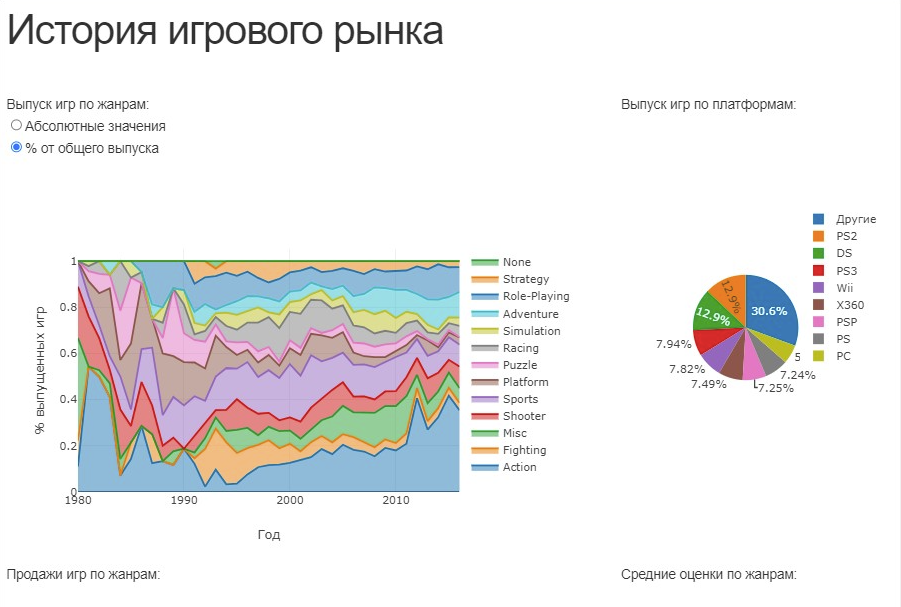

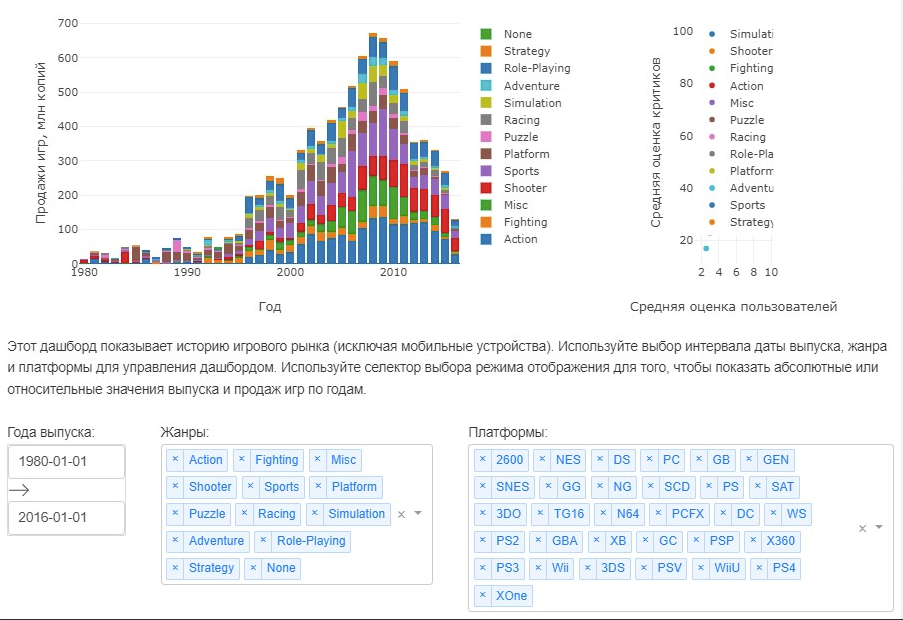